# Major Imports

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import os
import nltk

# Set a specific directory for NLTK data
os.environ['NLTK_DATA'] = '/home/matania/nltk_data'
nltk.data.path.append('/home/matania/nltk_data')

# Download required resources to that directory
nltk.download('punkt', download_dir='/home/matania/nltk_data')
nltk.download('stopwords', download_dir='/home/matania/nltk_data')

[nltk_data] Downloading package punkt to /home/matania/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matania/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# --- 1. Load Data ---

In [15]:
try:
    # Adjust path if your CSV is elsewhere
    news_df = pd.read_csv('../data/raw/financial_news.csv')
except FileNotFoundError:
    print("Error: financial_news.csv not found. Please ensure it's in the 'data/raw' directory.")


print("--- Data Understanding ---")
print("Shape:", news_df.shape)
print("\nInfo:")
news_df.info()
print("\nFirst 5 rows:")
print(news_df.head())
print("\nMissing values:")
print(news_df.isnull().sum())

--- Data Understanding ---
Shape: (1407328, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB

First 5 rows:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                       

# --- 2. Data Cleaning & Preprocessing (Basic) ---

In [16]:
# Convert 'date' to datetime objects
# The format includes timezone offset, pandas handles this well
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce') # errors='coerce' will turn unparseable dates into NaT

# Drop rows where date conversion failed (if any)
news_df.dropna(subset=['date'], inplace=True)

# Ensure 'headline' is string
news_df['headline'] = news_df['headline'].astype(str)

# --- 3. Descriptive Statistics ---


--- Descriptive Statistics ---

Headline Length Stats:
count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64


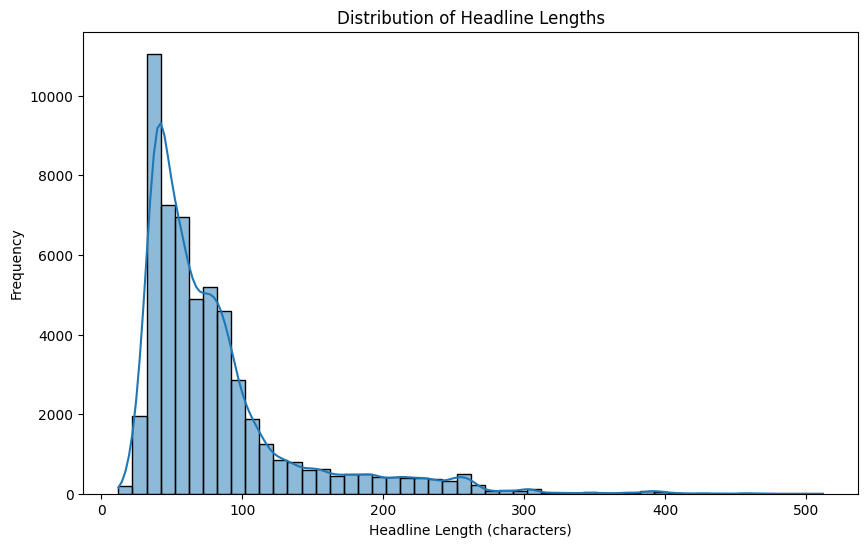


Top 20 Most Active Publishers:
publisher
Benzinga Newsdesk          14750
Lisa Levin                 12408
ETF Professor               4362
Paul Quintaro               4212
Benzinga Newsdesk           3177
Benzinga Insights           2332
Vick Meyer                  2128
Charles Gross               1790
Hal Lindon                  1470
Benzinga_Newsdesk           1239
Eddie Staley                1003
vishwanath@benzinga.com      924
Shanthi Rexaline             887
Monica Gerson                611
Wayne Duggan                 465
Nelson Hem                   345
Jayson Derrick               337
Craig Jones                  310
luke@benzinga.com            271
Javier Hasse                 250
Name: count, dtype: int64


/tmp/ipykernel_922705/3608080163.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='viridis')


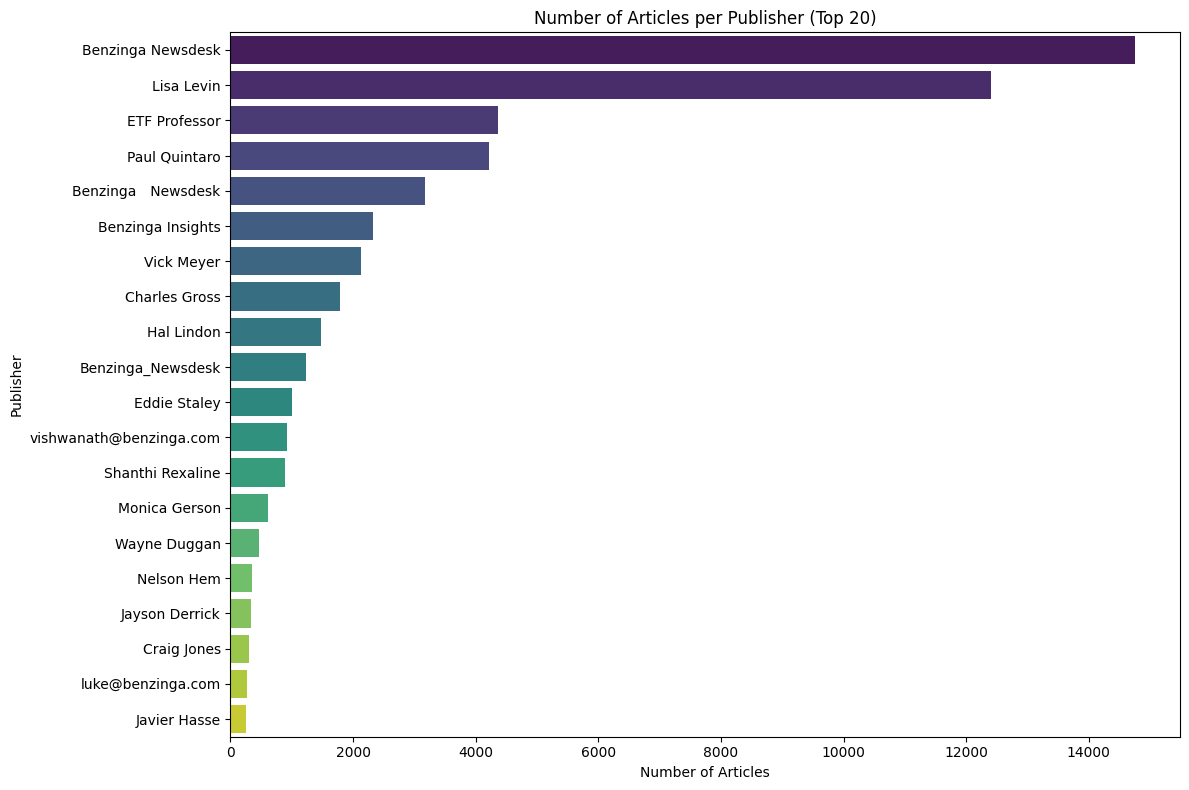

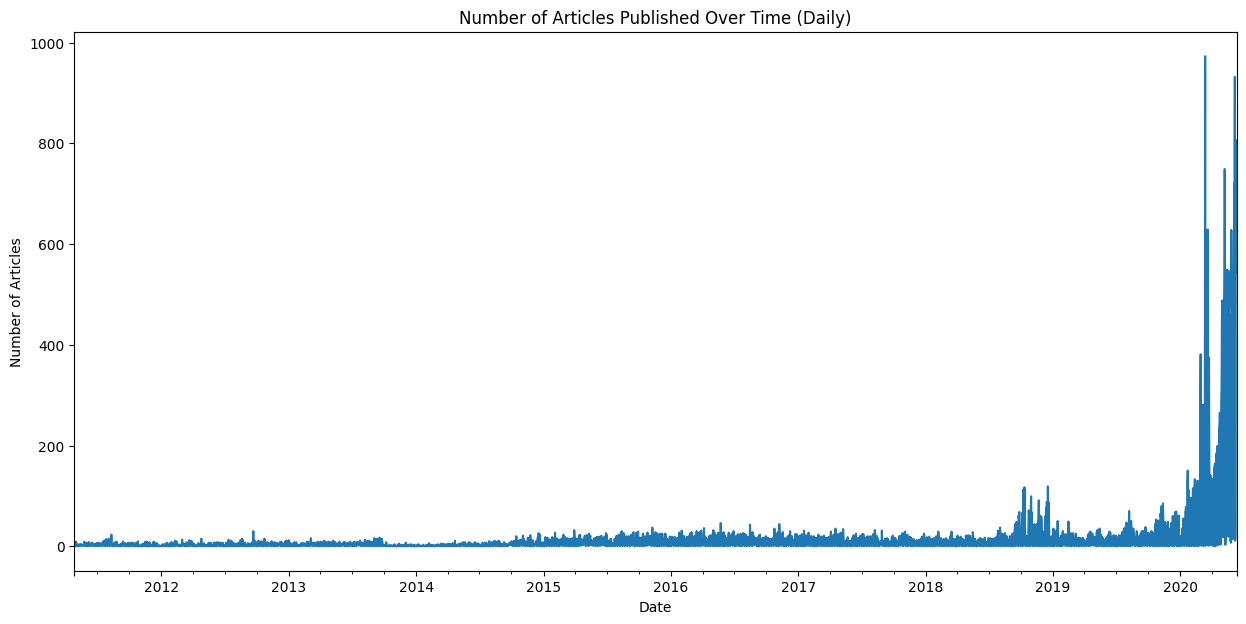

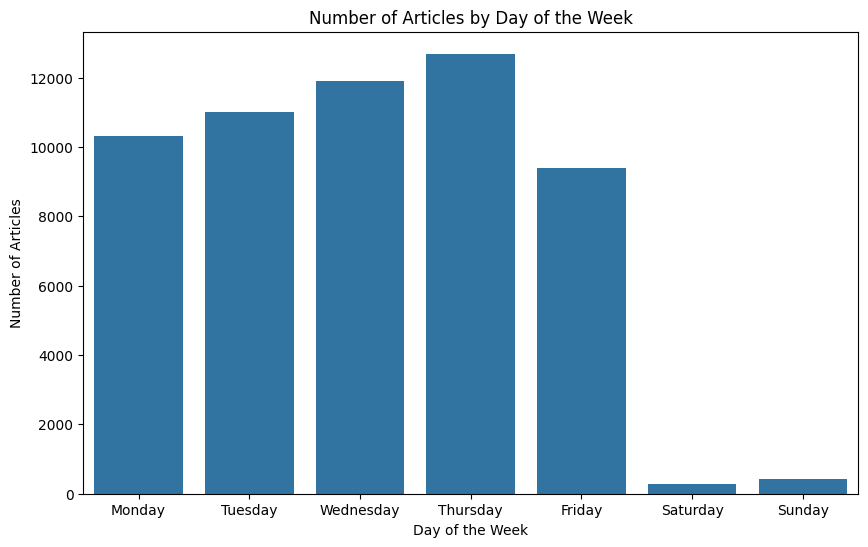

In [17]:
print("\n--- Descriptive Statistics ---")
# Headline length
news_df['headline_length'] = news_df['headline'].apply(len)
print("\nHeadline Length Stats:")
print(news_df['headline_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(news_df['headline_length'], bins=50, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Articles per publisher
publisher_counts = news_df['publisher'].value_counts().nlargest(20) # Top 20
print("\nTop 20 Most Active Publishers:")
print(publisher_counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='viridis')
plt.title('Number of Articles per Publisher (Top 20)')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')
plt.tight_layout()
plt.show()

# Publication dates trends
news_df.set_index('date', inplace=True) # Set date as index for time series analysis
articles_per_day = news_df['headline'].resample('D').count()

plt.figure(figsize=(15, 7))
articles_per_day.plot()
plt.title('Number of Articles Published Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Day of week analysis
news_df['day_of_week'] = news_df.index.day_name()
day_of_week_counts = news_df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.figure(figsize=(10, 6))
sns.barplot(x=day_of_week_counts.index, y=day_of_week_counts.values)
plt.title('Number of Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()

# Reset index if needed for further non-time-series operations, or keep it if mainly doing time-based
news_df.reset_index(inplace=True)


# --- 4. Text Analysis (Basic Keywords/Topic Modeling Idea) ---

In [28]:
import re

print("\n--- Basic Text Analysis ---")
stop_words = set(stopwords.words('english'))

# Simple keyword extraction from headlines
all_headlines_text = ' '.join(news_df['headline'].str.lower())
# Use regex to tokenize words (alphanumeric only)
words = re.findall(r'\b\w+\b', all_headlines_text)
filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
word_counts = Counter(filtered_words)
print("\nMost common words in headlines (Top 20):")
print(word_counts.most_common(20))

# Using CountVectorizer for N-grams (e.g., bi-grams)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20) # Top 20 bigrams
bigrams = vectorizer.fit_transform(news_df['headline'])
bigram_counts = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'count': bigrams.sum(axis=0).A1 # .A1 converts matrix to 1D array
}).sort_values('count', ascending=False)
print("\nMost common bigrams (Top 20):")
print(bigram_counts)


--- Basic Text Analysis ---

Most common words in headlines (Top 20):
[('stocks', 12794), ('0', 9901), ('week', 9029), ('52', 8453), ('shares', 8393), ('trading', 6575), ('hit', 5902), ('eps', 5531), ('market', 5482), ('price', 5046), ('companies', 4778), ('target', 4676), ('several', 4650), ('sales', 4429), ('higher', 4271), ('estimate', 3818), ('lows', 3741), ('session', 3394), ('maintains', 3266), ('us', 3180)]

Most common bigrams (Top 20):
               bigram  count
0             52 week   8251
12         stocks hit   5847
3              hit 52   5846
8        price target   4585
2   companies trading   4082
19          week lows   3687
15     trading higher   3517
13      stocks moving   2841
17         week highs   2561
16      trading lower   2152
7              new 52   2095
14         stocks set   2057
11            set new   2057
6             mid day   1992
10       raises price   1911
1      biggest movers   1890
4        lowers price   1769
5       lows thursday   1764


# --- 5. Time Series Analysis (Publication Frequency) ---

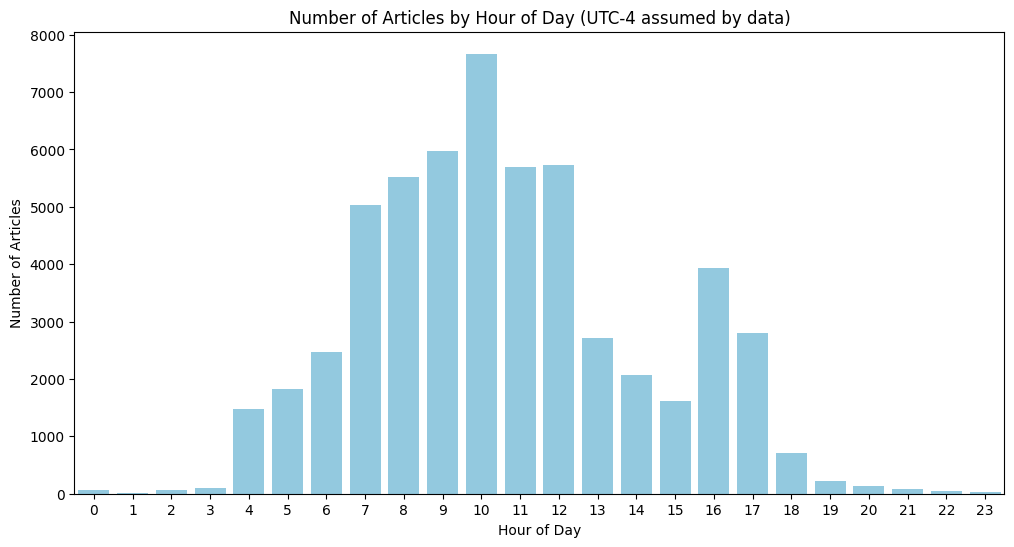


--- Publisher Analysis ---

Recall: Top Most Active Publishers:
publisher
Benzinga Newsdesk          14750
Lisa Levin                 12408
ETF Professor               4362
Paul Quintaro               4212
Benzinga Newsdesk           3177
Benzinga Insights           2332
Vick Meyer                  2128
Charles Gross               1790
Hal Lindon                  1470
Benzinga_Newsdesk           1239
Eddie Staley                1003
vishwanath@benzinga.com      924
Shanthi Rexaline             887
Monica Gerson                611
Wayne Duggan                 465
Nelson Hem                   345
Jayson Derrick               337
Craig Jones                  310
luke@benzinga.com            271
Javier Hasse                 250
Name: count, dtype: int64


In [29]:

# Already covered with 'articles_per_day' plot.
# Additional: Publication hour analysis
news_df['hour_of_day'] = pd.to_datetime(news_df['date']).dt.hour # Ensure 'date' is datetime
hour_counts = news_df['hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='skyblue')
plt.title('Number of Articles by Hour of Day (UTC-4 assumed by data)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks(range(24))
plt.show()
# Note: The prompt says UTC-4. Pandas handles this if the offset is in the string.
# If you need to convert to UTC: news_df['date_utc'] = pd.to_datetime(news_df['date']).dt.tz_convert('UTC')

print("\n--- Publisher Analysis ---")
# news_df['publisher_domain'] = news_df['publisher'][news_df['publisher'].str.contains('@')].apply(lambda x: x.split('@')[1] if isinstance(x, str) and '@' in x else None)
# domain_counts = news_df['publisher_domain'].value_counts()
# print("\nPublisher Email Domain Counts:")
# print(domain_counts)

print("\nRecall: Top Most Active Publishers:")
print(publisher_counts) # This was calculated in Descriptive Statistics